In [2]:
# Import Libraries
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Function to extract features
def extract_features(file_path):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path, sr=None)
    
    # Extract MFCCs (13 coefficients is common)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    
    # Take the mean of the MFCCs over time (flatten to 1D array)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    return mfccs_mean

# Define audio files directory
audio_speech = 'AudioWAV'

# Define empty lists to store features and labels
features = []
labels = []

# Loop over each file in the directory
for file_name in os.listdir(audio_speech):
    if file_name.endswith('.wav'):  # Ensure the file has the correct extension
        file_path = os.path.join(audio_speech, file_name)
        
        # Extract features
        mfccs_mean = extract_features(file_path)
        
        # Parse label from the filename (adjust based on your file name structure)
        # Example: "1001_WSI_SAD_XX.wav" -> "SAD"
        label = file_name.split('_')[2]
        
        # Append the feature array and label to respective lists
        features.append(mfccs_mean)
        labels.append(label)

# Convert features and labels into a DataFrame
features_df = pd.DataFrame({
    'Features': features,  # Each row contains the flattened MFCC mean array
    'Label': labels        # Corresponding emotion label
})

# Print the DataFrame to inspect
print("Features DataFrame:")
print(features_df)

# Inspect unique labels extracted from file names
unique_labels = sorted(set(labels))
print("Unique Labels Extracted from File Names:", unique_labels)


Features DataFrame:
                                               Features Label
0     [-306.0274, 92.670235, 8.491312, 23.965403, 7....   ANG
1     [-346.39963, 95.83912, 10.516282, 31.619215, 1...   DIS
2     [-321.42026, 94.76091, 8.155396, 23.32324, 11....   FEA
3     [-303.30374, 92.52889, 4.2312317, 27.970133, 1...   HAP
4     [-335.4959, 100.39331, 9.384935, 30.160906, 11...   NEU
...                                                 ...   ...
7437  [-413.36737, 96.38628, 46.36954, 14.591497, 20...   DIS
7438  [-426.0141, 91.230385, 49.76284, 20.57389, 22....   FEA
7439  [-370.4879, 90.63811, 38.969696, 19.76201, 14....   HAP
7440  [-393.18124, 94.35328, 45.251865, 12.303625, 1...   NEU
7441  [-428.9433, 95.96591, 47.516315, 18.359037, 19...   SAD

[7442 rows x 2 columns]
Unique Labels Extracted from File Names: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


In [5]:
# Initialize the LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# Verify the mapping between numeric and descriptive labels
label_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Label Mapping (Numeric to Descriptive):", label_mapping)

# Apply the LabelEncoder to the 'Label' column in the features DataFrame
features_df['Label'] = le.fit_transform(features_df['Label'])

# Separate features and labels
# Convert the 'Features' column into a NumPy array (each entry is a flattened feature array)
X = np.array(features_df['Features'].tolist())  # Features as 2D NumPy array
y = features_df['Label'].values  # Labels as 1D NumPy array

# Train-Test-Validation Split
# First, split the data into 80% (train+validation) and 20% (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now, split the remaining 80% into 60% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # 0.25 of 80% = 20%

# Print the split sizes for verification
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Label Mapping (Numeric to Descriptive): {0: 'ANG', 1: 'DIS', 2: 'FEA', 3: 'HAP', 4: 'NEU', 5: 'SAD'}
Training set size: 4464
Validation set size: 1489
Test set size: 1489


In [6]:
# Convert the data splits to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Define the neural network architecture for Speech Emotion Recognition (SER)
class SERModel(nn.Module):
    
    # The initializer (__init__) sets up the layers and operations for the network.
    def __init__(self, input_size, num_classes):
        super(SERModel, self).__init__()
        
        # Takes 'input_size' as input features and maps to 128 neurons.
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    # Define the forward pass, which outlines how data flows through the model layers.
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        # Return the output of the network.
        return x

# Model parameters
input_size = X_train.shape[1]  # Number of features per sample
num_classes = len(label_mapping)  # Number of emotion classes

# Initialize the model
model = SERModel(input_size=input_size, num_classes=num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculations during validation
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    val_accuracy = 100 * correct / total
    
    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {running_train_loss / len(train_loader):.4f}, "
          f"Validation Loss: {running_val_loss / len(val_loader):.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

# Test the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculations during testing
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/20], Train Loss: 2.8983, Validation Loss: 1.7954, Validation Accuracy: 17.13%
Epoch [2/20], Train Loss: 1.8010, Validation Loss: 1.7739, Validation Accuracy: 19.27%
Epoch [3/20], Train Loss: 1.7880, Validation Loss: 1.7393, Validation Accuracy: 32.03%
Epoch [4/20], Train Loss: 1.7606, Validation Loss: 1.7048, Validation Accuracy: 29.08%
Epoch [5/20], Train Loss: 1.7300, Validation Loss: 1.6633, Validation Accuracy: 32.03%
Epoch [6/20], Train Loss: 1.7013, Validation Loss: 1.6089, Validation Accuracy: 32.03%
Epoch [7/20], Train Loss: 1.6822, Validation Loss: 1.6270, Validation Accuracy: 31.50%
Epoch [8/20], Train Loss: 1.6677, Validation Loss: 1.5819, Validation Accuracy: 31.70%
Epoch [9/20], Train Loss: 1.6648, Validation Loss: 1.5880, Validation Accuracy: 32.77%
Epoch [10/20], Train Loss: 1.6547, Validation Loss: 1.5949, Validation Accuracy: 33.31%
Epoch [11/20], Train Loss: 1.6585, Validation Loss: 1.5845, Validation Accuracy: 33.24%
Epoch [12/20], Train Loss: 1.6477, Valida

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Placeholder lists to store true and predicted labels
y_true = []
y_pred = []

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    # Evaluate the model on the test set
    for X_batch, y_batch in test_loader: 
        outputs = model(X_batch)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Extract predicted class indices
        
        # Append true and predicted labels
        y_true.extend(y_batch.cpu().numpy())  # Convert true labels to numpy
        y_pred.extend(predicted.cpu().numpy())  # Convert predicted labels to numpy

# Convert lists to numpy arrays for consistency
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate descriptive class names using label mapping
class_names = [label_mapping[i] for i in range(len(label_mapping))]
print("Class Names for Evaluation:", class_names)

# Generate a classification report with zero_division set to 0
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:")
print(report)

Class Names for Evaluation: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
Classification Report:
              precision    recall  f1-score   support

         ANG       0.50      0.66      0.57       254
         DIS       0.26      0.11      0.16       254
         FEA       0.00      0.00      0.00       254
         HAP       0.26      0.23      0.25       255
         NEU       0.22      0.01      0.02       218
         SAD       0.29      0.92      0.44       254

    accuracy                           0.33      1489
   macro avg       0.26      0.32      0.24      1489
weighted avg       0.26      0.33      0.24      1489



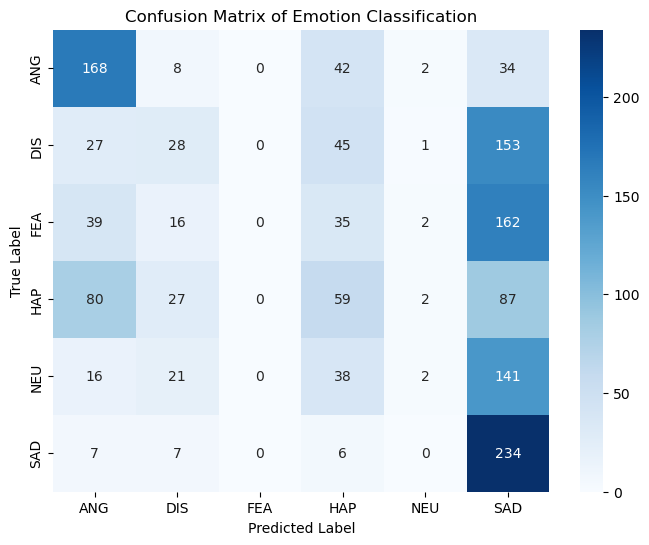

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Emotion Classification")
plt.show()